# Assignment 4 - Document Classification
Document classification problem.

**Preprocessing Steps includes:**

1. Lowercase and remove line breaks/tabs
2. Remove digits
3. Remove punctuation/special characters (keep words & spaces)
4. Collapse multiple spaces into one
5. Tokenize and remove stopwords
6. Apply stemming and lemmatization

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer
import tensorflow as tf
from sklearn.preprocessing import label_binarize

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
# Read the file
df = pd.read_csv('df_file.csv')

# Check values count among category
print(df.head())
df = df[['Text', 'Label']].dropna()
df['Label'] = df['Label'].astype(int)
print(df['Label'].value_counts())

                                                Text  Label
0  Budget to set scene for election\n \n Gordon B...      0
1  Army chiefs in regiments decision\n \n Militar...      0
2  Howard denies split over ID cards\n \n Michael...      0
3  Observers to monitor UK election\n \n Minister...      0
4  Kilroy names election seat target\n \n Ex-chat...      0
Label
1    511
4    510
0    417
2    401
3    386
Name: count, dtype: int64


In [3]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase and remove line breaks/tabs
    text = text.lower().replace("\n", " ").replace("\t", " ")

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Remove punctuation/special characters (keep words & spaces)
    text = re.sub(r'[^\w\s]', '', text)

    # Collapse multiple spaces into one
    text = re.sub(r'\s+', ' ', text)

    # Tokenize and remove stopwords
    tokens = text.strip().split()
    tokens = [word for word in tokens if word not in stop_words]

    # Apply stemming and lemmatization
    tokens = [stemmer.stem(word) for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

# Apply cleaning
df['clean_text'] = df['Text'].apply(clean_text)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['Label'], test_size=0.2, random_state=42)


In [5]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Naive Bayes
nb_pred = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred, average='weighted')

print(f"Naive Bayes - Accuracy: {nb_accuracy:.4f}, F1 Score: {nb_f1:.4f}")

Naive Bayes - Accuracy: 0.9596, F1 Score: 0.9595


In [6]:
svc_model = SVC(kernel='linear', probability=True)
svc_model.fit(X_train_tfidf, y_train)

# Linear SVC
svc_pred = svc_model.predict(X_test_tfidf)
svc_accuracy = accuracy_score(y_test, svc_pred)
svc_f1 = f1_score(y_test, svc_pred, average='weighted')

print(f"Linear SVC - Accuracy: {svc_accuracy:.4f}, F1 Score: {svc_f1:.4f}")

Linear SVC - Accuracy: 0.9798, F1 Score: 0.9797


In [7]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=100)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=100)

# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

# LSTM
lstm_pred = lstm_model.predict(X_test_pad)
lstm_pred = lstm_pred.argmax(axis=1)
lstm_accuracy = accuracy_score(y_test, lstm_pred)
lstm_f1 = f1_score(y_test, lstm_pred, average='weighted')

print(f"LSTM - Accuracy: {lstm_accuracy:.4f}, F1 Score: {lstm_f1:.4f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 345ms/step - accuracy: 0.2084 - loss: 2.0817 - val_accuracy: 0.2742 - val_loss: 1.5488
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.3548 - loss: 1.4441 - val_accuracy: 0.5169 - val_loss: 1.1669
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - accuracy: 0.5733 - loss: 1.0214 - val_accuracy: 0.6382 - val_loss: 0.8845
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 402ms/step - accuracy: 0.7224 - loss: 0.7413 - val_accuracy: 0.6921 - val_loss: 0.7443
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 549ms/step - accuracy: 0.7847 - loss: 0.5636 - val_accuracy: 0.7888 - val_loss: 0.5982
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.9041 - loss: 0.2877 - val_accuracy: 0.8404 - val_loss: 0.4625
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - accuracy: 0.9495 - loss: 0.1817 - val_accuracy: 0.8449 - val_loss: 0.5025
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - accuracy: 0.9493 - loss: 0.1652 - val_accuracy: 0.9348

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts, labels):
    input_ids, attention_masks = [], []
    for text in texts:
        encoding = tokenizer.encode_plus(text, truncation=True, padding='max_length', max_length=128, return_tensors='tf')
        input_ids.append(encoding['input_ids'][0])
        attention_masks.append(encoding['attention_mask'][0])
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_masks), tf.convert_to_tensor(labels)

X_train_enc, X_train_mask, y_train_enc = encode_texts(X_train.tolist(), y_train.tolist())
X_test_enc, X_test_mask, y_test_enc = encode_texts(X_test.tolist(), y_test.tolist())

bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

steps_per_epoch = len(X_train_enc) // 16
num_train_steps = steps_per_epoch * 2
optimizer, _ = create_optimizer(init_lr=2e-5, num_train_steps=num_train_steps, num_warmup_steps=0)

bert_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bert_model.fit([X_train_enc, X_train_mask], y_train_enc, epochs=2, batch_size=16, validation_split=0.1)

bert_preds = bert_model.predict([X_test_enc, X_test_mask]).logits.argmax(axis=1)
print("BERT Accuracy:", accuracy_score(y_test, bert_preds))
print("BERT F1 Score:", f1_score(y_test, bert_preds, average='weighted'))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
101/101 [==============================] - 107s 472ms/step - loss: 1.8005 - accuracy: 0.7091 - val_loss: 0.5428 - val_accuracy: 0.9551
Epoch 2/2
14/14 [==============================] - 7s 269ms/step
BERT Accuracy: 0.9415730337078652
BERT F1 Score: 0.9416303387321031


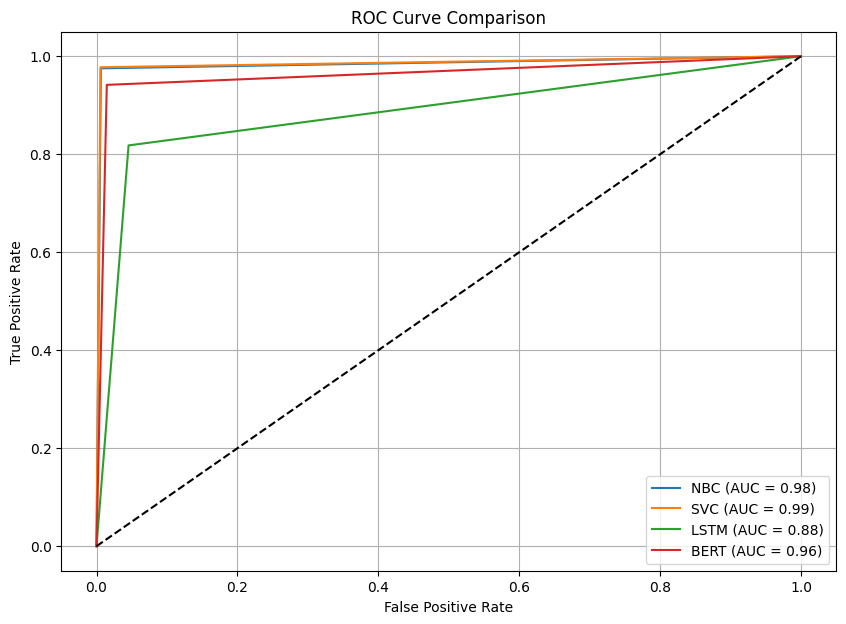

In [ ]:
y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])

models_preds = {
    'NBC': label_binarize(nb_pred, classes=[0,1,2,3,4]),
    'SVC': label_binarize(svc_pred, classes=[0,1,2,3,4]),
    'LSTM': label_binarize(lstm_pred, classes=[0,1,2,3,4]),
    'BERT': label_binarize(bert_preds, classes=[0,1,2,3,4]),
}

plt.figure(figsize=(10, 7))
for name, pred in models_preds.items():
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), pred.ravel())
    roc_auc = roc_auc_score(y_test_bin, pred, average='weighted', multi_class='ovr')
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()
